# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы . Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Данные уже прошли предварительную обработку.


## Цель проекта

Необходимо построить модель, которая спрогнозирует подходящий тариф для клиента. Метрика качества модели - *accuracy*. Требования по метрике - не менее 0.75.

## План работы

1. Загрузка данных.
2. Подготовка выборок для машинного обучения.
3. Обучение моделей.
4. Проверка качества моделей на тестовой выборке.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- **сalls** — количество звонков,
- **minutes** — суммарная длительность звонков в минутах,
- **messages** — количество sms-сообщений,
- **mb_used** — израсходованный интернет-трафик в Мб,
- **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Настройка окружения

In [1]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Загрузка данных

In [2]:
# загрузим предоставленный датасет
try:
    df = pd.read_csv('/datasets/users_behavior.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

## Изучение данных

In [3]:
# изучим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Датафрейм имеет 5 столбцов и 3214 строк.

In [5]:
# Проверим на дубликаты
df.duplicated().sum()

0

Дубликаты отстутствуют.

In [6]:
# Проверим на наличие пропусков.
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Пропуски отсутствуют.

Изменим тип данных в столбцах 'calls' и 'messages', так как количество звонком и сообщений - целые числа.

In [7]:
df['calls'] = df['calls'].astype(int)
df['messages'] = df['messages'].astype(int)

In [8]:
# проверим 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


### Вывод

Данные загрузились без ошибок. Датафрейм имеет размерность в 5 столбцов и 3214 строк. Дубликаты и пропуски отсутствуют. Изменен тип данных в столбцах 'calls' и 'messages' с float64 на int64.

## Подготвка данных к машинному обучению

Разделим данные на матрицу признаков и целевой столбец.

In [9]:
# создаем матрицу признаков
features = df.drop(['is_ultra'], axis=1)

# создаем целевой столбец
target = df['is_ultra']

Оценим как распределены данные в целевом столбце (тариф Ультра и Смарт).

In [10]:
# напишем функцию оценки
def distrib_target(selection):
    print(selection.value_counts())
    print('-' * 20)
    print('Соотношение Ультра / Смарт:',
          selection[selection == 1].size / selection[selection == 0].size)

In [11]:
# оценим распределение
distrib_target(target)

is_ultra
0    2229
1     985
Name: count, dtype: int64
--------------------
Соотношение Ультра / Смарт: 0.44190219829519967


Можно сделать вывод о том, что имеем неравномерное распределение признаков в целевом столбце. Учтем это при создании выборок для моделей, контролировать будем по соотношению.

Разделим выборку на тренировочную (train) - 60 % и валидацилнную (valid) - 40%. Учтем параметр stratify, для сохранения равномерного распределения классов в таргетных столбцах.

In [12]:
# создаем распределения
features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size = 0.4, random_state=12345, stratify = target)

Разделим валидационную выборку на тестовую и валидационную, на пополам. Будем иметь итоговое распределение: тренировочная - 60%, валидационная - 20%, тестовая - 20%. При текущем разделении так же учтем параметр stratify.

In [13]:
# создаем распределения
features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size = 0.5, random_state=12345, stratify = target_valid)
features_valid.shape, features_test.shape, target_valid.shape, target_test.shape

((643, 4), (643, 4), (643,), (643,))

Проверим таргетные столбцы на распределение классов.

In [14]:
# оценим распределения
dict_selection = {'Изначальная выборка:':target, 'Обучающая выборка:':target_train,\
                  'Валидационная выборка:':target_valid, 'Тестовая выборка:':target_test}
for key, val in dict_selection.items():
    print(key)
    print('-'*20)
    distrib_target(val)
    print('-'*50)
    print(''*2)

Изначальная выборка:
--------------------
is_ultra
0    2229
1     985
Name: count, dtype: int64
--------------------
Соотношение Ультра / Смарт: 0.44190219829519967
--------------------------------------------------

Обучающая выборка:
--------------------
is_ultra
0    1337
1     591
Name: count, dtype: int64
--------------------
Соотношение Ультра / Смарт: 0.44203440538519073
--------------------------------------------------

Валидационная выборка:
--------------------
is_ultra
0    446
1    197
Name: count, dtype: int64
--------------------
Соотношение Ультра / Смарт: 0.44170403587443946
--------------------------------------------------

Тестовая выборка:
--------------------
is_ultra
0    446
1    197
Name: count, dtype: int64
--------------------
Соотношение Ультра / Смарт: 0.44170403587443946
--------------------------------------------------



Видим, что получили выборки запланированных размеров. В таргетном столбце сохранилось соотношение распределения классов.

### Вывод

Исходные данные были разбиты на три выборки: обучающая, валидационная и тестовая, в сотношении 60/20/20 %. При создании выборок целевых значений был применен метод равномерного распределения классов (стратификация).

## Обучение моделей

### Модель дерево решений

In [15]:
# инициализируем модель с первоначальной настройкой по глубине
model_dt = DecisionTreeClassifier(random_state=12345, max_depth = 5)

# обучим модель
model_dt.fit(features_train, target_train)

# подготовим прогноз на валидационной выборке
pred_dt_valid = model_dt.predict(features_valid)

# проверим точность модели
accuracy_score(target_valid, pred_dt_valid)

0.7853810264385692

Получили модель с точностью более 0.75. Попробуем улучшить точность модели, путем варьирования гиперпараметра max_depth.

In [16]:
best_result_tree = 0
best_max_depth = 0
for depth in range(1, 26):

    # инициализируем модель с настройкой по глубине, задаваемой в цикле
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    # обучим модель
    model_dt.fit(features_train, target_train)
    # подготовим прогноз
    pred_dt_valid = model_dt.predict(features_valid)
    # посчитаем точность
    result = accuracy_score(target_valid, pred_dt_valid)

    # найдем лучшую модель
    if result > best_result_tree:
        best_result_tree = result
        best_max_depth = depth
        best_model_dt = model_dt
        
        
print('Лучшая точность модели:', best_result_tree)
print('Значение гиперпараметра max_depth, при лучшей точности модели:', best_max_depth)
best_model_dt

Лучшая точность модели: 0.80248833592535
Значение гиперпараметра max_depth, при лучшей точности модели: 8


DecisionTreeClassifier(max_depth=8, random_state=12345)

### Модель случайный лес

In [17]:
# инициализируем модель с первоначальными настройками по глубине и количеству деревьев 
model_rf = RandomForestClassifier(random_state=12345, max_depth = 5, n_estimators=10)

# обучим модель
model_rf.fit(features_train, target_train)

# подготовим прогноз на валидационной выборке
pred_rf_valid = model_rf.predict(features_valid)

# проверим точность модели
accuracy_score(target_valid, pred_rf_valid)

0.7884914463452566

Получили модель с точностью более 0.75. Попробуем улучшить точность модели, путем варьирования гиперпараметров max_depth, n_estimators и min_samples_leaf.

In [18]:
best_result_forest = 0
best_max_depth = 0
best_estimator = 0
best_sample = 0

for depth in range(1, 21):
    for estimator in range(10, 51, 5):
        for sample in range(1, 5):
            # инициализируем модель с настройками, задаваемыми в цикле
            model_rf = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators = estimator,\
                                                  min_samples_leaf = sample)
            # обучим модель
            model_rf.fit(features_train, target_train)
            # подготовим прогноз
            pred_rf_valid = model_rf.predict(features_valid)
            # посчитаем точность
            result = accuracy_score(target_valid, pred_rf_valid)
        
            # найдем лучшую модель       
            if result > best_result_forest:
                best_result_forest = result
                best_max_depth = depth
                best_estimator = estimator
                best_sample = sample
                best_model_rf = model_rf
            
print('Лучшая точность модели:', best_result_forest)
print('Значение гиперпараметра max_depth, при лучшей точности модели:', best_max_depth)
print('Значение гиперпараметра n_estimators, при лучшей точности модели:', best_estimator)
print('Значение гиперпараметра min_samples_leaf, при лучшей точности модели:', best_sample)
best_model_rf

Лучшая точность модели: 0.8211508553654744
Значение гиперпараметра max_depth, при лучшей точности модели: 9
Значение гиперпараметра n_estimators, при лучшей точности модели: 40
Значение гиперпараметра min_samples_leaf, при лучшей точности модели: 1


RandomForestClassifier(max_depth=9, n_estimators=40, random_state=12345)

### Модель логистическая регрессия

In [19]:
# инициализируем модель
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

# обучим модель
model_lr.fit(features_train, target_train)

# проверим модель на валидационной выборке
pred_lr_valid = model_lr.predict(features_valid)

# проверим точность модели
result_lr = accuracy_score(target_valid, pred_lr_valid)
result_lr

0.7387247278382582

### Вывод

Были изучены следующие модели:
- дерево решений;
- случайный лес;
- логистическая регресси.

Модели были обучены на обучающих выборках.
Проверка моделей производилась на валидационной выборке.
Оценка точности моделей, проводилась на валидационной выборке целевых значений.

Для модели дерево решений подобран следующий оптимальный гиперпараметр: max_depth = 8
Для модели случайный лес подобраны следующие оптимальные гиперпараметры: max_depth = 9, n_estimators = 40, min_samples_leaf = 1

Результаты точности моделей (accuracy), при оптимальных гиперпараметрах:

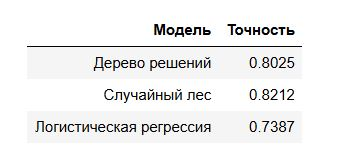


По результатам проведенной работы, можно сделать вывод, что на валидационной выборке, наилучшей точностью обладает модель "лес решений", при подобранных оптимальных гиперпараметрах.

## Тестирование лучшей модели

In [20]:
# получим прогноз лучшей модели, на тестовой выборке
prediction_test_rf = best_model_rf.predict(features_test)

# оценим точность
print('Точность модели "случайный лес" на тестовой выборке:', accuracy_score(target_test, prediction_test_rf))

Точность модели "случайный лес" на тестовой выборке: 0.8087091757387247


### Вывод

Таким образом, на тестовой выборке модель "случайный лес" показала точность предсказания - 0.8087

## Проверка ьодели на адекватность

Для проверки адекватности наших моделей, будем сравнивать их точность предсказаний с простейшей (dummy) моделью. Гиперпараметр strategy выберем "most_frequent".

In [21]:
# импоритруем модель
from sklearn.dummy  import  DummyClassifier

# инициализируем модель
dummy_clf = DummyClassifier(strategy = 'most_frequent', random_state = 12345)

# обучим модель
dummy_clf.fit(features_train, target_train)

# проверим точность
dummy_clf.score(features_test, target_test)

0.6936236391912908

### Вывод

Таким образом, результаты проверки простейшей моделью, показал, что простейшая классификация дает точность 0.6936. Это значит, что наша лучшая обученная модель дает результат выше - 0.8087, для тестовой выборки.

## Общий вывод

1. Полученные данные загрузились без ошибок. Датафрейм имеет размерность в 5 столбцов и 3214 строк. Дубликаты и пропуски отсутствуют. Изменен тип данных в столбцах 'calls' и 'messages' с float64 на int64.


2. Исходные данные были разбиты на три выборки: обучающая, валидационная и тестовая, в сотношении 60/20/20 %. При создании выборок целевых значений был применен метод равномерного распределения классов (стратификация).


3. Были изучены следующие модели:
- дерево решений;
- случайный лес;
- логистическая регресси.

Модели были обучены на обучающих выборках.
Проверка моделей производилась на валидационной выборке.
Оценка точности моделей, проводилась на валидационной выборке целевых значений.

Для модели дерево решений подобран следующий оптимальный гиперпараметр: max_depth = 8
Для модели случайный лес подобраны следующие оптимальные гиперпараметры: max_depth = 9, n_estimators = 40, min_samples_leaf = 1

Результаты точности моделей (accuracy), при оптимальных гиперпараметрах:

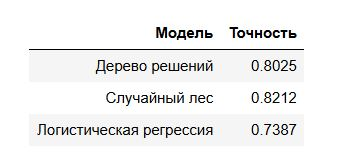


По результатам проведенной работы, можно сделать вывод, что на валидационной выборке, наилучшей точностью обладает модель "лес решений", при подобранных оптимальных гиперпараметрах.


4. На тестовой выборке наилучшую точность показала модель "случайный лес" показала точность предсказания - 0.8087.


5. Была проведена проверка модели на адекватность. Результаты проверки простейшей моделью, показал, что простейшая классификация дает точность 0.6936. Это значит, что наша лучшая обученная модель дает результат выше - 0.8087, для тестовой выборки.

